In [52]:
import numpy as np
from keras import models
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, UpSampling2D
from keras.layers.core import Dense, Activation, Dropout, Flatten, Reshape
from keras.regularizers import l1
import keras.backend as K
# from autoencoder_layers import DependentDense, Deconvolution2D, DePool2D
# from helpers import show_representations

GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
from scipy.misc import imresize
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
from keras import optimizers
from keras.models import Model



def get_data():
    with h5py.File(GTEx_directory + '/data/better_covering_patches/' + 'GTEX-111YS-0626_128.hdf5','r') as f:
        data = f['patches'].value
    return data

from keras.datasets import mnist

mnist_data = mnist.load_data()

len(mnist_data[1][1])


def build_models():
    c1 = Convolution2D(64, 3, 3, border_mode='same', input_shape=(128, 128, 3))
    c2 = Convolution2D(32, 3, 3, border_mode='same')
    mp1 = MaxPooling2D(pool_size=(2, 2))
    mp2 = MaxPooling2D(pool_size=(2, 2))
    dc1 = Conv2DTranspose(32, 3, border_mode='same')
    dc2 = Conv2DTranspose(3, 3, border_mode='same')
    up1 = UpSampling2D(size=(2, 2))
    up2 = UpSampling2D(size=(2, 2))
    d = Dense(1024, activity_regularizer=l1(1e-5))




    # =========      ENCODER     ========================

    def generate_encoder():
        model = models.Sequential()
        model.add(c1)
        model.add(Activation('tanh'))
        model.add(mp1)
        model.add(Dropout(0.5))
        model.add(c2)
        model.add(Activation('tanh'))
        model.add(mp2)
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dropout(0.5))
        dependent_dense_size = model.layers[-1].output_shape[-1]
        model.add(d)
        model.add(Activation('tanh'))
        return model

    # =========      DECODER     ========================

    def generate_decoder():
        model = models.Sequential()
        model.add(Dense(32*32*32, input_shape=(1024,)))
        model.add(Activation('tanh'))
        model.add(Dropout(0.5))
        model.add(Reshape((32, 32, 32)))
        model.add(up1)
        model.add(dc1)
        model.add(Activation('tanh'))
        model.add(Dropout(0.5))
        model.add(up2)
        model.add(dc2)
        model.add(Activation('tanh'))
        model.add(Dropout(0.5))
        return model

    encoder = generate_encoder()
    decoder = generate_decoder()

    autoencoder = Model(encoder.input, decoder(encoder(encoder.input)))
    return autoencoder, encoder

autoencoder, encoder = build_models()
data = get_data()
data = 1 - (np.array([imresize(x,(128,128)) for x in data]) / 255.)

# data = mnist_data[0][0][0:1000]
# data = np.array([imresize(np.repeat(x[:, :, np.newaxis], 3, axis=2),(128, 128)) for x in data]) / 255.

rmsprop = optimizers.RMSprop(lr=0.001)

def custom_loss(y_true, y_pred):
#     red_error = K.mean(K.square(y_pred[:,:,:,0] - y_true[:,:,:,0]), axis=-1)
#     green_error = K.mean(K.square(y_pred[:,:,:,1] - y_true[:,:,:,1]), axis=-1)
    loss = K.mean(K.abs(y_pred - y_true))
    return loss * 50
autoencoder.compile(optimizer=rmsprop, loss=custom_loss)


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(128, 128,..., padding="same")`
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:37: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:40: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(32, 3, padding="same")`
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(3, 3, padding="same")`


In [57]:
history = autoencoder.fit(data, data, nb_epoch=100, batch_size=50,validation_split=0.2, callbacks=[EarlyStopping(patience=3)])
autoencoder.save(GTEx_directory + '/models/autoencoder.h5')

Train on 6827 samples, validate on 1707 samples
Epoch 1/100
  50/6827 [..............................] - ETA: 20s - loss: 9.4377

/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


6827/6827 [==============================] - 19s - loss: 9.8077 - val_loss: 7.0982
Epoch 2/100
6827/6827 [==============================] - 19s - loss: 9.4248 - val_loss: 6.5857
Epoch 3/100
6827/6827 [==============================] - 19s - loss: 9.2212 - val_loss: 7.1115
Epoch 4/100
6827/6827 [==============================] - 19s - loss: 9.1464 - val_loss: 7.6756
Epoch 5/100
6827/6827 [==============================] - 19s - loss: 9.2796 - val_loss: 6.6183
Epoch 6/100
6827/6827 [==============================] - 19s - loss: 9.2093 - val_loss: 6.5379
Epoch 7/100
6827/6827 [==============================] - 19s - loss: 9.0454 - val_loss: 6.8407
Epoch 8/100
6827/6827 [==============================] - 19s - loss: 8.9894 - val_loss: 7.3406
Epoch 9/100
6827/6827 [==============================] - 19s - loss: 8.9931 - val_loss: 6.3122
Epoch 10/100
6827/6827 [==============================] - 19s - loss: 8.9092 - val_loss: 5.6803
Epoch 11/100
6827/6827 [==============================] - 19s

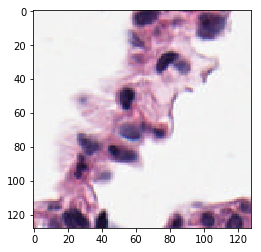

In [58]:
plt.imshow(1 - data[0])

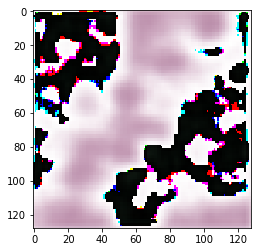

In [59]:
reconstruction = 1 - np.squeeze(autoencoder.predict((data[0]).reshape(1,128,128,3)))
plt.imshow(reconstruction)

In [60]:
from keras.applications import InceptionV3

In [62]:
inception_model = InceptionV3(weights='imagenet')

TypeError: Expected int32, got list containing Tensors of type '_Message' instead.